In [51]:
pip install geopandas



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [52]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point


In [53]:
bird = pd.read_csv("../data/df_all_bird.csv")


/var/folders/h0/khxnf7v151599zc19wcwyyfw0000gn/T/ipykernel_9336/636068297.py:1: DtypeWarning: Columns (0: RISERVATO) have mixed types. Specify dtype option on import or set low_memory=False.
  bird = pd.read_csv("../data/df_all_bird.csv")


In [54]:
lime = pd.read_csv("../data/df_all_lime.csv")


In [55]:
voi= pd.read_csv("../data/df_all_voi.csv")


In [56]:
bird.columns

Index(['ID_VEICOLO', 'DATAORA_INIZIO', 'DATAORA_FINE',
       'LATITUDINE_INIZIO_CORSA', 'LONGITUTIDE_INIZIO_CORSA',
       'LATITUDINE_FINE_CORSA', 'LONGITUTIDE_FINE_CORSA', 'PERCORSO',
       'DISTANZA_KM', 'DURATA_MIN', 'RISERVATO', 'DURATA_H', 'SPEED_KMH',
       'HAV_DIST_KM', 'date', 'hour', 'year'],
      dtype='str')

In [57]:
lime.columns

Index(['ID_ORGANIZZAZIONE', 'ID_VEICOLO', 'DATAORA_INIZIO', 'DATAORA_FINE',
       'LATITUDINE_INIZIO_CORSA', 'LONGITUTIDE_INIZIO_CORSA',
       'LATITUDINE_FINE_CORSA', 'LONGITUTIDE_FINE_CORSA', 'PERCORSO',
       'DISTANZA_KM', 'DURATA_MIN', 'RISERVATO', 'BATTERIA_INIZIO_CORSA',
       'BATTERIA_FINE_CORSA', 'DURATA_H', 'SPEED_KMH', 'YEAR', 'MONTH', 'HOUR',
       'WEEKDAY', 'DAY', 'YEAR_MONTH', 'IS_WEEKEND', 'WEEK'],
      dtype='str')

In [58]:
voi.columns

Index(['Identificativo noleggio', 'Targa veicolo', 'Data inizio corsa',
       'Data fine corsa', 'Lat inizio corsa_coordinate',
       'Lon inizio corsa_coordinate', 'Lat fine corsa_coordinate',
       'Lon fine corsa_coordinate', 'Tempo Tot', 'KM Tot', 'Prenotazione',
       'Batteria inizio', 'Batteria fine', 'source_file', 'start_hour',
       'start_date', 'weekday', 'is_weekend', 'duration_hours', 'speed_kmh',
       'trip_date', 'year', 'hour', 'month', 'week'],
      dtype='str')

In [59]:
zones = gpd.read_file("../data/zone_statistiche_geo/zone_statistiche_geo.shp")

zones.columns

Index(['ZONASTAT', 'DENOM', 'geometry'], dtype='str')

In [60]:
zones.head()

,ZONASTAT,DENOM,geometry
0,70,Pilonetto,"POLYGON ((1395895.985 4988060.107, 1395898.044..."
1,42,Borgata Vittoria,"POLYGON ((1395519.219 4994610.663, 1395528.682..."
2,55,Ospizio di Carità,"POLYGON ((1392498.38 4988368.989, 1392593.575 ..."
3,06,Piazza Vittorio Veneto,"POLYGON ((1396903.882 4991059.344, 1396929.822..."
4,09,Piazza Madama Cristina (Borgo San Salvario),"POLYGON ((1395852.47 4990177.979, 1395864.654 ..."


In [61]:
zones = zones.to_crs("EPSG:4326")


In [62]:
zones.crs


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [63]:
import geopandas as gpd
from shapely.geometry import Point

In [64]:
bird_gdf = gpd.GeoDataFrame(
    bird,
    geometry=gpd.points_from_xy(
        bird["LONGITUTIDE_INIZIO_CORSA"],
        bird["LATITUDINE_INIZIO_CORSA"]
    ),
    crs="EPSG:4326"
)

In [65]:
bird_gdf["dest_geometry"] = gpd.points_from_xy(
    bird["LONGITUTIDE_FINE_CORSA"],
    bird["LATITUDINE_FINE_CORSA"]
)

In [66]:
bird_with_origin_zone = gpd.sjoin(
    bird_gdf,
    zones,
    how="left",
    predicate="within"
)

In [67]:
bird_with_origin_zone["ZONASTAT"].isna().sum()


np.int64(12088)

In [68]:
len(bird)

840738

In [69]:
bird_dest_gdf = gpd.GeoDataFrame(
    bird_with_origin_zone.drop(columns="geometry"),
    geometry=bird_with_origin_zone["dest_geometry"],
    crs="EPSG:4326"
)


In [70]:
bird_od = gpd.sjoin(
    bird_dest_gdf,
    zones,
    how="left",
    predicate="within",
    lsuffix="orig",
    rsuffix="dest"
)

In [71]:
od_bird_all = (
    bird_od
    .groupby(["ZONASTAT_orig", "ZONASTAT_dest"])
    .size()
    .reset_index(name="trips")
)

In [72]:
od_bird_all.head()

,ZONASTAT_orig,ZONASTAT_dest,trips
0,01,01,1226
1,01,02,136
2,01,03,684
3,01,04,892
4,01,05,787


In [73]:
bird_morning = bird_od[(bird_od["hour"] >= 7) & (bird_od["hour"] <= 9)]

od_bird_morning = (
    bird_morning
    .groupby(["ZONASTAT_orig", "ZONASTAT_dest"])
    .size()
    .reset_index(name="trips")
)


In [74]:
bird_evening = bird_od[(bird_od["hour"] >= 16) & (bird_od["hour"] <= 19)]

od_bird_evening = (
    bird_evening
    .groupby(["ZONASTAT_orig", "ZONASTAT_dest"])
    .size()
    .reset_index(name="trips")
)


In [75]:
zones_centroids = zones.copy()
zones_centroids["geometry"] = zones_centroids.geometry.centroid


/var/folders/h0/khxnf7v151599zc19wcwyyfw0000gn/T/ipykernel_9336/4079273467.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  zones_centroids["geometry"] = zones_centroids.geometry.centroid


In [76]:
zones_centroids.head()


,ZONASTAT,DENOM,geometry
0,70,Pilonetto,POINT (7.68586 45.04066)
1,42,Borgata Vittoria,POINT (7.67801 45.09632)
2,55,Ospizio di Carità,POINT (7.64401 45.03857)
3,06,Piazza Vittorio Veneto,POINT (7.69424 45.06616)
4,09,Piazza Madama Cristina (Borgo San Salvario),POINT (7.68227 45.05848)


In [77]:
od = od_bird_all.copy()

od = od.merge(
    zones_centroids[["ZONASTAT", "geometry"]],
    left_on="ZONASTAT_orig",
    right_on="ZONASTAT",
    how="left"
).rename(columns={"geometry": "orig_geom"})

od = od.merge(
    zones_centroids[["ZONASTAT", "geometry"]],
    left_on="ZONASTAT_dest",
    right_on="ZONASTAT",
    how="left"
).rename(columns={"geometry": "dest_geom"})


In [78]:
from shapely.geometry import LineString

od["geometry"] = od.apply(
    lambda row: LineString([row["orig_geom"], row["dest_geom"]]),
    axis=1
)

od_lines = gpd.GeoDataFrame(od, geometry="geometry", crs="EPSG:4326")


In [79]:
threshold = od_lines["trips"].quantile(0.9)
od_lines_filt = od_lines[od_lines["trips"] >= threshold]


<Axes: >

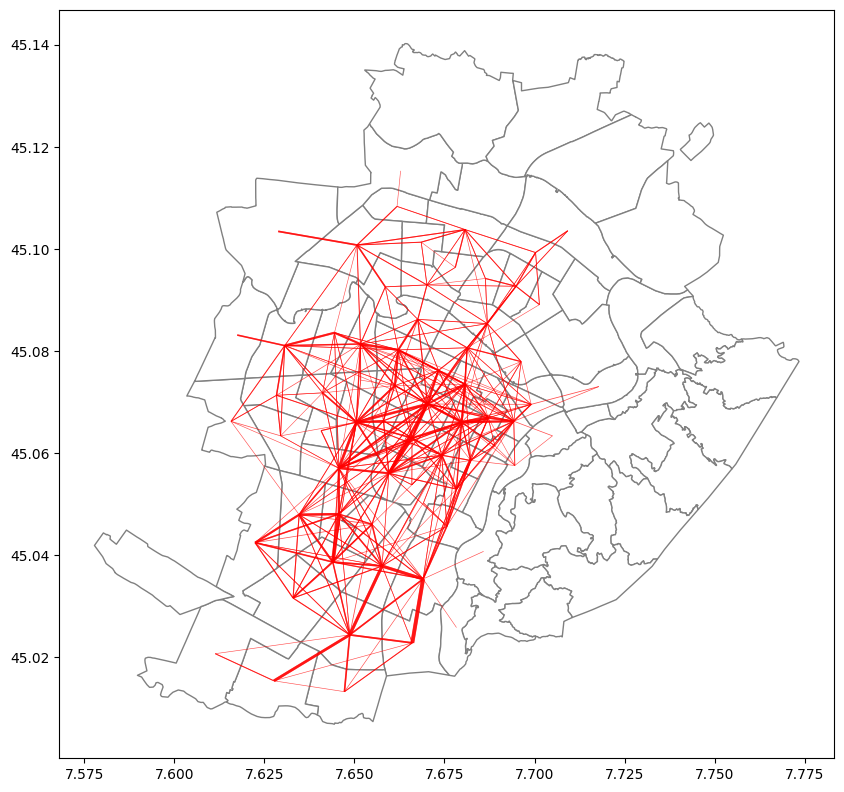

In [80]:
ax = zones.plot(figsize=(10, 10), color="white", edgecolor="grey")
od_lines_filt.plot(
    ax=ax,
    linewidth=od_lines_filt["trips"] / od_lines_filt["trips"].max() * 5,
    color="red",
    alpha=0.7
)


In [81]:
# مرتب‌سازی برای خوانایی
od_bird_all_sorted = (
    od_bird_all
    .sort_values("trips", ascending=False)
    .reset_index(drop=True)
)

od_bird_all_sorted.head(15)


,ZONASTAT_orig,ZONASTAT_dest,trips
0,57,57,4160
1,56,56,3746
2,61,61,3711
3,16,16,3687
4,53,53,3551
5,55,55,3506
6,50,50,3429
7,33,33,3424
8,35,35,3400
9,48,48,2875


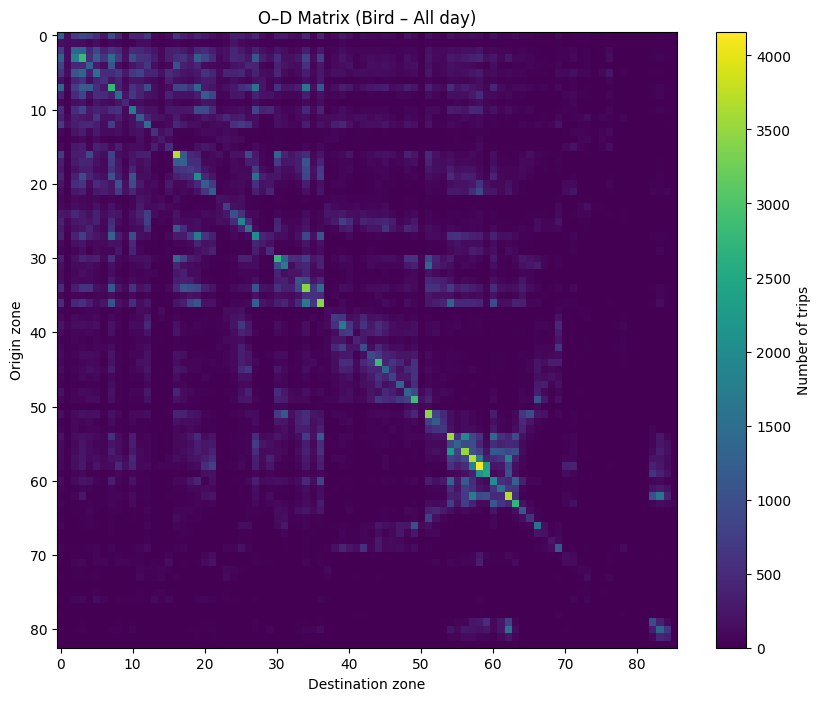

In [82]:
import matplotlib.pyplot as plt

# pivot کردن برای ساخت ماتریس
od_matrix = od_bird_all.pivot(
    index="ZONASTAT_orig",
    columns="ZONASTAT_dest",
    values="trips"
).fillna(0)

plt.figure(figsize=(10, 8))
plt.imshow(od_matrix, aspect="auto")
plt.colorbar(label="Number of trips")
plt.xlabel("Destination zone")
plt.ylabel("Origin zone")
plt.title("O–D Matrix (Bird – All day)")
plt.show()


In [83]:
zones_centroids = zones.copy()
zones_centroids["geometry"] = zones_centroids.geometry.centroid

/var/folders/h0/khxnf7v151599zc19wcwyyfw0000gn/T/ipykernel_9336/1060344795.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  zones_centroids["geometry"] = zones_centroids.geometry.centroid


In [84]:
od_map = od_bird_all.copy()

od_map = od_map.merge(
    zones_centroids[["ZONASTAT", "geometry"]],
    left_on="ZONASTAT_orig",
    right_on="ZONASTAT",
    how="left"
).rename(columns={"geometry": "orig_geom"})

od_map = od_map.merge(
    zones_centroids[["ZONASTAT", "geometry"]],
    left_on="ZONASTAT_dest",
    right_on="ZONASTAT",
    how="left"
).rename(columns={"geometry": "dest_geom"})

In [85]:
from shapely.geometry import LineString

od_map["geometry"] = od_map.apply(
    lambda r: LineString([r["orig_geom"], r["dest_geom"]]),
    axis=1
)

od_lines = gpd.GeoDataFrame(
    od_map,
    geometry="geometry",
    crs="EPSG:4326")

In [86]:
threshold = od_lines["trips"].quantile(0.9)
od_lines_top = od_lines[od_lines["trips"] >= threshold]


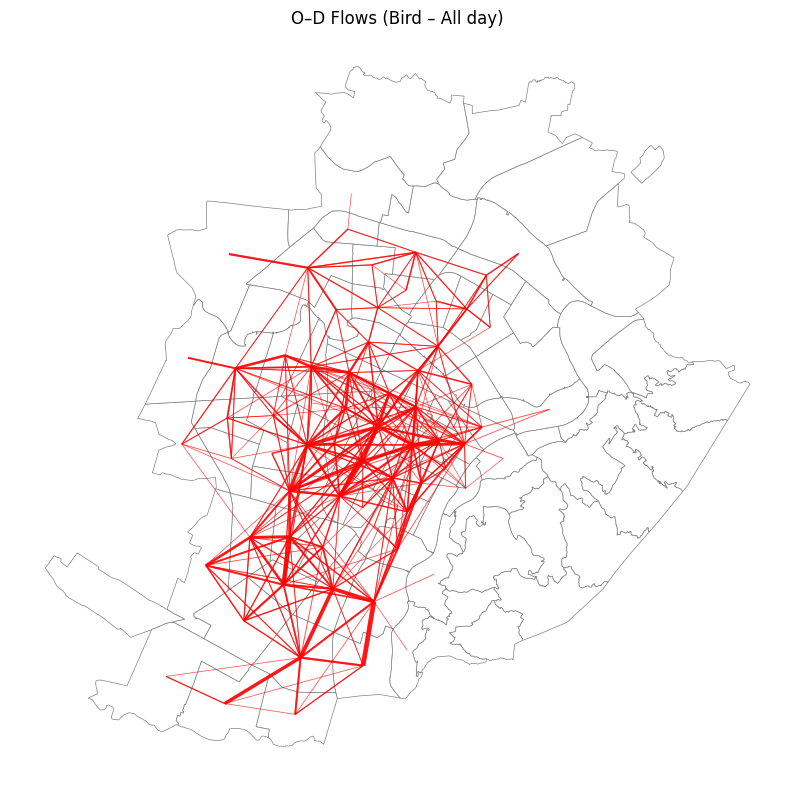

In [87]:
fig, ax = plt.subplots(figsize=(10, 10))

zones.plot(
    ax=ax,
    color="white",
    edgecolor="grey",
    linewidth=0.5
)

od_lines_top.plot(
    ax=ax,
    linewidth=od_lines_top["trips"] / od_lines_top["trips"].max() * 6,
    color="red",
    alpha=0.7
)

plt.title("O–D Flows (Bird – All day)")
plt.axis("off")
plt.show()


In [88]:
import folium
import geopandas as gpd


In [89]:
pip install nbconvert



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [90]:
import folium

m = folium.Map(
    location=[45.0677, 7.6825],  # Turin
    zoom_start=13
)

m


In [91]:
od_bird_all_sorted.columns


Index(['ZONASTAT_orig', 'ZONASTAT_dest', 'trips'], dtype='str')

In [92]:
import geopandas as gpd

zones = gpd.read_file("../data/zone_statistiche_geo/zone_statistiche_geo.shp")

zones['centroid'] = zones.geometry.centroid
zones['lat'] = zones.centroid.y
zones['lon'] = zones.centroid.x


In [93]:
print(zones.crs)  

EPSG:3003


In [94]:
zones = zones.to_crs(epsg=4326)

In [95]:
zones['centroid'] = zones.geometry.centroid
zones['lat'] = zones.centroid.y
zones['lon'] = zones.centroid.x


/var/folders/h0/khxnf7v151599zc19wcwyyfw0000gn/T/ipykernel_9336/2778992968.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  zones['centroid'] = zones.geometry.centroid
/var/folders/h0/khxnf7v151599zc19wcwyyfw0000gn/T/ipykernel_9336/2778992968.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  zones['lat'] = zones.centroid.y
/var/folders/h0/khxnf7v151599zc19wcwyyfw0000gn/T/ipykernel_9336/2778992968.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  zones['lon'] = zones.centroid.x


In [96]:
od_map = od_bird_all_sorted.merge(
    zones[['ZONASTAT', 'lat', 'lon']],
    left_on='ZONASTAT_orig',
    right_on='ZONASTAT',
    how='left'
).rename(columns={'lat':'orig_lat','lon':'orig_lon'})

od_map = od_map.merge(
    zones[['ZONASTAT', 'lat', 'lon']],
    left_on='ZONASTAT_dest',
    right_on='ZONASTAT',
    how='left'
).rename(columns={'lat':'dest_lat','lon':'dest_lon'})


In [97]:
od_map[['orig_lat','orig_lon']].describe()


,orig_lat,orig_lon
count,6177.000000,6177.000000
mean,45.068753,7.670656
std,0.022833,0.028753
min,45.013158,7.595398
25%,45.055700,7.650557
50%,45.069542,7.670145
75%,45.085299,7.688281
max,45.115907,7.742398


In [98]:
m = folium.Map(location=[45.0677, 7.6825], zoom_start=12)

for _, row in od_map.head(50).iterrows():
    folium.PolyLine(
        locations=[
            [row['orig_lat'], row['orig_lon']],
            [row['dest_lat'], row['dest_lon']]
        ],
        weight=4,
        color='red',
        opacity=0.8
    ).add_to(m)

m


In [99]:
m.save("od_flows_bird.html")

In [100]:
import numpy as np

max_trips = od_map['trips'].max()

for _, row in od_map.head(50).iterrows():
    weight = 1 + 8 * (row['trips'] / max_trips)  # بین 1 تا 9

    folium.PolyLine(
        locations=[
            [row['orig_lat'], row['orig_lon']],
            [row['dest_lat'], row['dest_lon']]
        ],
        weight=weight,
        color='red',
        opacity=0.7
    ).add_to(m)


In [101]:
for _, row in od_map.head(50).iterrows():

    popup_text = f"""
    Origin: {row['ZONASTAT_orig']} <br>
    Destination: {row['ZONASTAT_dest']} <br>
    Trips: {row['trips']}
    """

    folium.PolyLine(
        locations=[
            [row['orig_lat'], row['orig_lon']],
            [row['dest_lat'], row['dest_lon']]
        ],
        weight=weight,
        color='red',
        opacity=0.7,
        popup=popup_text
    ).add_to(m)

m


In [102]:
# مرتب‌سازی بر اساس تعداد سفر
od_sorted = od_map.sort_values('trips', ascending=False)

# محاسبه سهم از کل سفرها
total_trips = od_sorted['trips'].sum()
od_sorted['share_%'] = 100 * od_sorted['trips'] / total_trips

# نمایش 10 جریان اصلی
od_sorted[['ZONASTAT_orig','ZONASTAT_dest','trips','share_%']].head(10)


,ZONASTAT_orig,ZONASTAT_dest,trips,share_%
0,57,57,4160,0.512834
1,56,56,3746,0.461797
2,61,61,3711,0.457482
3,16,16,3687,0.454524
4,53,53,3551,0.437758
5,55,55,3506,0.432210
6,50,50,3429,0.422718
7,33,33,3424,0.422102
8,35,35,3400,0.419143
9,48,48,2875,0.354422


In [103]:
# حذف سفرهای داخل یک زون
od_inter = od_map[
    od_map['ZONASTAT_orig'] != od_map['ZONASTAT_dest']
].copy()

# مرتب‌سازی مجدد
od_inter = od_inter.sort_values('trips', ascending=False)

# محاسبه سهم از کل سفرهای بین‌منطقه‌ای
total_inter = od_inter['trips'].sum()
od_inter['share_%'] = 100 * od_inter['trips'] / total_inter

# نمایش 10 جریان بین‌منطقه‌ای اصلی
od_inter[['ZONASTAT_orig','ZONASTAT_dest','trips','share_%']].head(10)


,ZONASTAT_orig,ZONASTAT_dest,trips,share_%
16,57,58,2364,0.336650
17,55,53,2256,0.321270
18,58,57,2102,0.299339
22,53,55,1992,0.283674
23,57,56,1871,0.266443
25,56,61,1832,0.260889
26,04,03,1788,0.254623
27,61,56,1745,0.248500
30,56,57,1712,0.243800
31,26,18,1692,0.240952


In [104]:
# مجموع خروجی‌ها (production)
production = od_map.groupby('ZONASTAT_orig')['trips'].sum().reset_index()
production = production.sort_values('trips', ascending=False)

# مجموع ورودی‌ها (attraction)
attraction = od_map.groupby('ZONASTAT_dest')['trips'].sum().reset_index()
attraction = attraction.sort_values('trips', ascending=False)

print("Top 5 Production Zones:")
display(production.head(5))

print("Top 5 Attraction Zones:")
display(attraction.head(5))


Top 5 Production Zones:


,ZONASTAT_orig,trips
7,08,29520
3,04,28693
34,33,25648
36,35,23724
5,06,20207


Top 5 Attraction Zones:


,ZONASTAT_dest,trips
34,33,25729
7,08,24961
3,04,22942
36,35,21870
16,16,20636


In [105]:
# سهم 5 زون اصلی از کل تولید
top5_prod_share = production.head(5)['trips'].sum() / production['trips'].sum() * 100

# سهم 5 زون اصلی از کل جذب
top5_attr_share = attraction.head(5)['trips'].sum() / attraction['trips'].sum() * 100

print(f"Top 5 Production Zones share: {top5_prod_share:.2f}%")
print(f"Top 5 Attraction Zones share: {top5_attr_share:.2f}%")


Top 5 Production Zones share: 15.75%
Top 5 Attraction Zones share: 14.32%


In [106]:
import numpy as np

# تبدیل درجه به رادیان
lat1 = np.radians(od_map['orig_lat'])
lon1 = np.radians(od_map['orig_lon'])
lat2 = np.radians(od_map['dest_lat'])
lon2 = np.radians(od_map['dest_lon'])

# اختلاف‌ها
dlat = lat2 - lat1
dlon = lon2 - lon1

# فرمول Haversine
a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
c = 2 * np.arcsin(np.sqrt(a))

R = 6371000  # شعاع زمین به متر

od_map['distance_m'] = R * c

od_map[['distance_m','trips']].describe()


,distance_m,trips
count,6177.000000,6177.000000
mean,4109.289963,131.322487
std,2045.533131,276.408664
min,0.000000,1.000000
25%,2553.987460,10.000000
50%,3948.329039,40.000000
75%,5469.755952,134.000000
max,12984.374479,4160.000000


In [107]:
od_map[['distance_m','trips']].corr()


,distance_m,trips
distance_m,1.000000,-0.503527
trips,-0.503527,1.000000


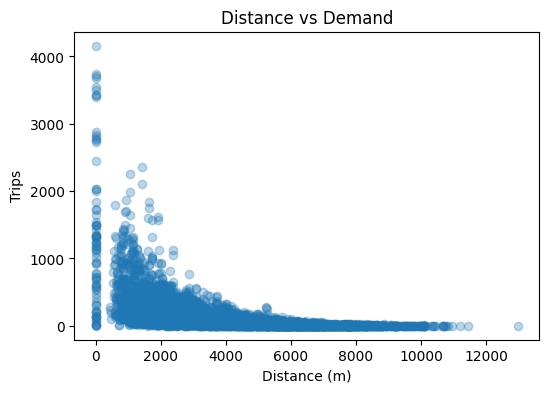

In [108]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.scatter(od_map['distance_m'], od_map['trips'], alpha=0.3)
plt.xlabel("Distance (m)")
plt.ylabel("Trips")
plt.title("Distance vs Demand")
plt.show()


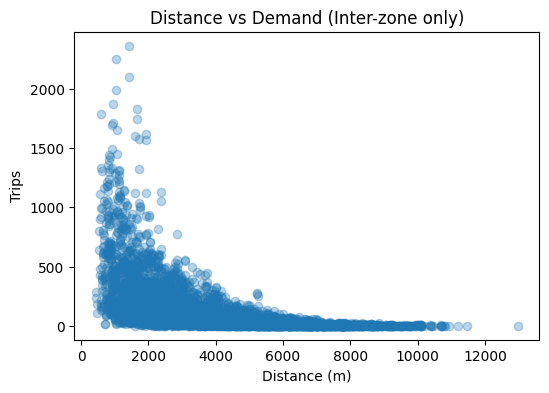

In [109]:
od_decay = od_map[od_map['distance_m'] > 0].copy()

plt.figure(figsize=(6,4))
plt.scatter(od_decay['distance_m'], od_decay['trips'], alpha=0.3)
plt.xlabel("Distance (m)")
plt.ylabel("Trips")
plt.title("Distance vs Demand (Inter-zone only)")
plt.show()


In [110]:
# حذف صفرها برای لگاریتم
od_model = od_decay[od_decay['trips'] > 0].copy()

# لگاریتم گرفتن
od_model['log_trips'] = np.log(od_model['trips'])

# رگرسیون ساده
coef = np.polyfit(od_model['distance_m'], od_model['log_trips'], 1)

beta = -coef[0]

print(f"Estimated distance-decay parameter (beta): {beta:.6f}")



Estimated distance-decay parameter (beta): 0.000673


In [111]:
# پارامترها
speed = 4.17  # m/s  (~15 km/h)
VOT = 10      # €/hour
unlock_fee = 1
price_per_min = 0.25

# زمان سفر (دقیقه)
od_map['time_min'] = od_map['distance_m'] / speed / 60

# هزینه پولی
od_map['monetary_cost'] = unlock_fee + price_per_min * od_map['time_min']

# هزینه زمانی (یورو)
od_map['time_cost'] = VOT * (od_map['time_min'] / 60)

# Generalised Cost
od_map['GC_scooter'] = od_map['monetary_cost'] + od_map['time_cost']

od_map[['distance_m','GC_scooter']].describe()


,distance_m,GC_scooter
count,6177.000000,6177.000000
mean,4109.289963,7.843342
std,2045.533131,3.406497
min,0.000000,1.000000
25%,2553.987460,5.253243
50%,3948.329039,7.575288
75%,5469.755952,10.108973
max,12984.374479,22.623325


In [112]:
od_map[['GC_scooter','trips']].corr()


,GC_scooter,trips
GC_scooter,1.000000,-0.503527
trips,-0.503527,1.000000


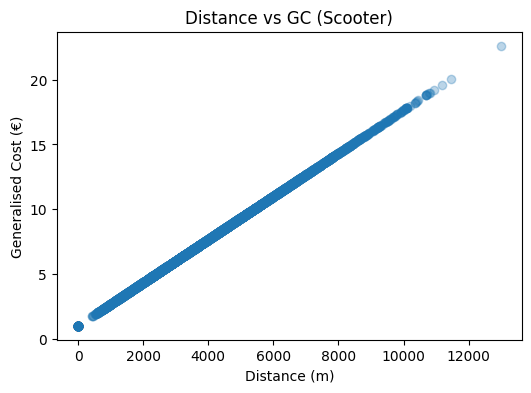

In [113]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.scatter(od_map['distance_m'], od_map['GC_scooter'], alpha=0.3)
plt.xlabel("Distance (m)")
plt.ylabel("Generalised Cost (€)")
plt.title("Distance vs GC (Scooter)")
plt.show()


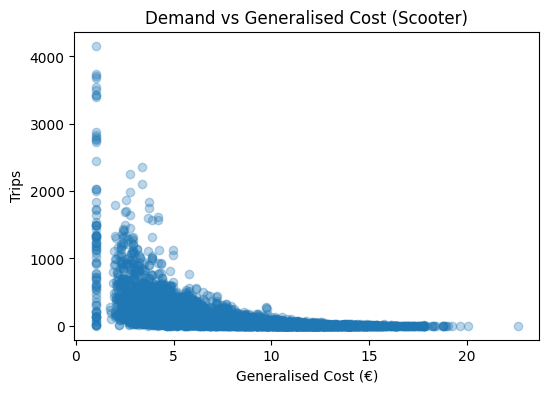

In [114]:
plt.figure(figsize=(6,4))
plt.scatter(od_map['GC_scooter'], od_map['trips'], alpha=0.3)
plt.xlabel("Generalised Cost (€)")
plt.ylabel("Trips")
plt.title("Demand vs Generalised Cost (Scooter)")
plt.show()


In [115]:
# حذف مقادیر صفر برای لگاریتم
od_gc_model = od_map[od_map['trips'] > 0].copy()

# لگاریتم تقاضا
od_gc_model['log_trips'] = np.log(od_gc_model['trips'])

# رگرسیون ساده: log(trips) = a - beta * GC
coef_gc = np.polyfit(od_gc_model['GC_scooter'], od_gc_model['log_trips'], 1)

beta_gc = -coef_gc[0]

print(f"Estimated cost-decay parameter (beta_GC): {beta_gc:.6f}")


Estimated cost-decay parameter (beta_GC): 0.406318


In [116]:
# میانگین‌ها
mean_GC = od_map['GC_scooter'].mean()
mean_trips = od_map['trips'].mean()

# کشش در نقطه میانگین
elasticity = -beta_gc * mean_GC

print(f"Elasticity of demand w.r.t Generalised Cost (at mean): {elasticity:.3f}")


Elasticity of demand w.r.t Generalised Cost (at mean): -3.187


In [117]:
# R-squared برای مدل فاصله
coef_dist = np.polyfit(od_model['distance_m'], od_model['log_trips'], 1)
pred_dist = np.polyval(coef_dist, od_model['distance_m'])

ss_res_dist = np.sum((od_model['log_trips'] - pred_dist)**2)
ss_tot_dist = np.sum((od_model['log_trips'] - od_model['log_trips'].mean())**2)

r2_dist = 1 - ss_res_dist/ss_tot_dist

# R-squared برای مدل GC
coef_gc = np.polyfit(od_gc_model['GC_scooter'], od_gc_model['log_trips'], 1)
pred_gc = np.polyval(coef_gc, od_gc_model['GC_scooter'])

ss_res_gc = np.sum((od_gc_model['log_trips'] - pred_gc)**2)
ss_tot_gc = np.sum((od_gc_model['log_trips'] - od_gc_model['log_trips'].mean())**2)

r2_gc = 1 - ss_res_gc/ss_tot_gc

print(f"R² (Distance model): {r2_dist:.3f}")
print(f"R² (GC model): {r2_gc:.3f}")


R² (Distance model): 0.593
R² (GC model): 0.603


In [118]:
od_map.columns


Index(['ZONASTAT_orig', 'ZONASTAT_dest', 'trips', 'ZONASTAT_x', 'orig_lat',
       'orig_lon', 'ZONASTAT_y', 'dest_lat', 'dest_lon', 'distance_m',
       'time_min', 'monetary_cost', 'time_cost', 'GC_scooter'],
      dtype='str')

In [119]:
od_bird_all.columns


Index(['ZONASTAT_orig', 'ZONASTAT_dest', 'trips'], dtype='str')

In [120]:
%who


LineString	 Point	 R	 VOT	 a	 attraction	 ax	 beta	 beta_gc	 
bird	 bird_dest_gdf	 bird_evening	 bird_gdf	 bird_morning	 bird_od	 bird_with_origin_zone	 c	 coef	 
coef_dist	 coef_gc	 dlat	 dlon	 elasticity	 fig	 folium	 gpd	 lat1	 
lat2	 lime	 lon1	 lon2	 m	 max_trips	 mean_GC	 mean_trips	 np	 
od	 od_bird_all	 od_bird_all_sorted	 od_bird_evening	 od_bird_morning	 od_decay	 od_gc_model	 od_inter	 od_lines	 
od_lines_filt	 od_lines_top	 od_map	 od_matrix	 od_model	 od_sorted	 pd	 plt	 popup_text	 
pred_dist	 pred_gc	 price_per_min	 production	 r2_dist	 r2_gc	 row	 speed	 ss_res_dist	 
ss_res_gc	 ss_tot_dist	 ss_tot_gc	 threshold	 top5_attr_share	 top5_prod_share	 total_inter	 total_trips	 unlock_fee	 
voi	 weight	 zones	 zones_centroids	 


In [121]:
bird.columns


Index(['ID_VEICOLO', 'DATAORA_INIZIO', 'DATAORA_FINE',
       'LATITUDINE_INIZIO_CORSA', 'LONGITUTIDE_INIZIO_CORSA',
       'LATITUDINE_FINE_CORSA', 'LONGITUTIDE_FINE_CORSA', 'PERCORSO',
       'DISTANZA_KM', 'DURATA_MIN', 'RISERVATO', 'DURATA_H', 'SPEED_KMH',
       'HAV_DIST_KM', 'date', 'hour', 'year'],
      dtype='str')

In [122]:
# تعریف بازه‌های زمانی
time_periods = {
    "Morning Peak (7-9)": (7, 9),
    "Midday (11-13)": (11, 13),
    "Evening Peak (17-19)": (17, 19),
    "Night (22-23)": (22, 23)
}

# تست یک بازه (فقط صبح فعلاً)
h0, h1 = time_periods["Morning Peak (7-9)"]

bird_morning = bird[(bird['hour'] >= h0) & (bird['hour'] <= h1)]

bird_morning[['hour']].describe()


,hour
count,76593.000000
mean,8.005183
std,0.786504
min,7.000000
25%,7.000000
50%,8.000000
75%,9.000000
max,9.000000


In [123]:
bird_with_origin_zone.columns


Index(['ID_VEICOLO', 'DATAORA_INIZIO', 'DATAORA_FINE',
       'LATITUDINE_INIZIO_CORSA', 'LONGITUTIDE_INIZIO_CORSA',
       'LATITUDINE_FINE_CORSA', 'LONGITUTIDE_FINE_CORSA', 'PERCORSO',
       'DISTANZA_KM', 'DURATA_MIN', 'RISERVATO', 'DURATA_H', 'SPEED_KMH',
       'HAV_DIST_KM', 'date', 'hour', 'year', 'geometry', 'dest_geometry',
       'index_right', 'ZONASTAT', 'DENOM'],
      dtype='str')

In [124]:
# فیلتر صبح روی دیتای join شده
h0, h1 = time_periods["Morning Peak (7-9)"]

bird_morning_joined = bird_with_origin_zone[
    (bird_with_origin_zone['hour'] >= h0) &
    (bird_with_origin_zone['hour'] <= h1)
]

# ساخت O-D صبح (فقط مبدا فعلاً)
od_morning = (
    bird_morning_joined
    .groupby('ZONASTAT')
    .size()
    .reset_index(name='trips')
    .sort_values('trips', ascending=False)
)

od_morning.head(10)


,ZONASTAT,trips
7,08,2914
27,26,2876
36,35,2737
34,33,2726
30,29,2549
57,56,2521
16,16,2258
56,55,2081
54,53,2032
51,50,1866


In [125]:
bird.columns


Index(['ID_VEICOLO', 'DATAORA_INIZIO', 'DATAORA_FINE',
       'LATITUDINE_INIZIO_CORSA', 'LONGITUTIDE_INIZIO_CORSA',
       'LATITUDINE_FINE_CORSA', 'LONGITUTIDE_FINE_CORSA', 'PERCORSO',
       'DISTANZA_KM', 'DURATA_MIN', 'RISERVATO', 'DURATA_H', 'SPEED_KMH',
       'HAV_DIST_KM', 'date', 'hour', 'year'],
      dtype='str')

In [126]:
from shapely.geometry import Point
import geopandas as gpd

bird_dest = bird.copy()

bird_dest['geometry'] = bird_dest.apply(
    lambda row: Point(row['LONGITUTIDE_FINE_CORSA'], 
                      row['LATITUDINE_FINE_CORSA']),
    axis=1
)

bird_dest = gpd.GeoDataFrame(bird_dest, geometry='geometry', crs="EPSG:4326")


In [127]:
# پیدا کردن خودکار ستون طول و عرض مقصد
lon_col = [c for c in bird.columns if "LONGIT" in c and "FINE" in c][0]
lat_col = [c for c in bird.columns if "LATIT" in c and "FINE" in c][0]

print("Longitude column:", lon_col)
print("Latitude column:", lat_col)


Longitude column: LONGITUTIDE_FINE_CORSA
Latitude column: LATITUDINE_FINE_CORSA


In [128]:
from shapely.geometry import Point
import geopandas as gpd

bird_dest = bird.copy()

bird_dest["geometry"] = bird_dest.apply(
    lambda row: Point(row[lon_col], row[lat_col]),
    axis=1
)

bird_dest = gpd.GeoDataFrame(
    bird_dest,
    geometry="geometry",
    crs="EPSG:4326"
)


In [129]:
bird_dest.head()


,ID_VEICOLO,DATAORA_INIZIO,DATAORA_FINE,LATITUDINE_INIZIO_CORSA,LONGITUTIDE_INIZIO_CORSA,LATITUDINE_FINE_CORSA,LONGITUTIDE_FINE_CORSA,PERCORSO,DISTANZA_KM,DURATA_MIN,RISERVATO,DURATA_H,SPEED_KMH,HAV_DIST_KM,date,hour,year,geometry
0,8AD7P,2024-01-01 01:00:00,2024-01-01 01:22:00,45.071664,7.695770,45.058830,7.678815,NaN,3.20,22.05,NaN,0.367500,8.707483,1.951903,2024-01-01 01:00:00,1,2024,POINT (7.67882 45.05883)
1,XN4B6,2024-01-01 01:00:00,2024-01-01 01:03:00,45.052023,7.674939,45.052862,7.679611,NaN,0.50,3.08,NaN,0.051333,9.740260,0.378660,2024-01-01 01:00:00,1,2024,POINT (7.67961 45.05286)
2,JQ2JD,2024-01-01 01:02:00,2024-01-01 01:29:00,45.066525,7.682050,45.055685,7.672043,NaN,1.80,27.20,NaN,0.453333,3.970588,1.438974,2024-01-01 01:02:00,1,2024,POINT (7.67204 45.05568)
3,BD8V5,2024-01-01 01:02:00,2024-01-01 01:14:00,45.066468,7.681988,45.056301,7.673063,NaN,1.50,11.92,NaN,0.198667,7.550336,1.330182,2024-01-01 01:02:00,1,2024,POINT (7.67306 45.0563)
4,2YBLH,2024-01-01 01:03:00,2024-01-01 01:22:00,45.061798,7.680334,45.064752,7.694430,NaN,2.71,18.35,NaN,0.305833,8.861035,1.154845,2024-01-01 01:03:00,1,2024,POINT (7.69443 45.06475)


In [130]:
bird_dest.geometry.head()


0    POINT (7.67882 45.05883)
1    POINT (7.67961 45.05286)
2    POINT (7.67204 45.05568)
3     POINT (7.67306 45.0563)
4    POINT (7.69443 45.06475)
Name: geometry, dtype: geometry

<Axes: >

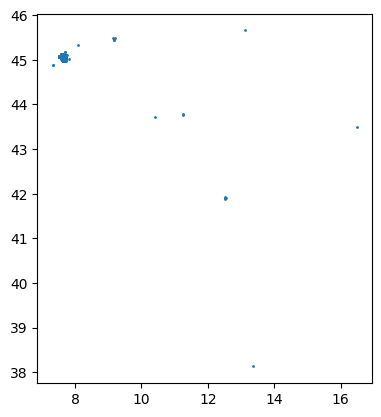

In [131]:
bird_dest.plot(markersize=1)


In [132]:
print("bird_dest CRS:", bird_dest.crs)
print("zones CRS:", zones.crs)


bird_dest CRS: EPSG:4326
zones CRS: EPSG:4326


In [133]:
# spatial join: assign destination zone
bird_with_dest_zone = gpd.sjoin(
    bird_dest,
    zones[['ZONASTAT', 'geometry']],
    how='left',
    predicate='within'
)


In [134]:
bird_with_dest_zone[['ZONASTAT']].head()


,ZONASTAT
0,09
1,19
2,10
3,10
4,06


In [135]:
bird_with_origin_zone[['ZONASTAT']].head()


,ZONASTAT
0,11
1,19
2,04
3,04
4,09


In [136]:
# فقط ستون zone را از هر کدام برداریم
origin_df = bird_with_origin_zone[['ZONASTAT', 'hour']].copy()
dest_df   = bird_with_dest_zone[['ZONASTAT']].copy()

# rename کنیم که قاطی نشود
origin_df = origin_df.rename(columns={'ZONASTAT': 'origin_zone'})
dest_df   = dest_df.rename(columns={'ZONASTAT': 'dest_zone'})

# indexها یکی هستند، پس مستقیم join می‌کنیم
od_full = origin_df.join(dest_df)

od_full.head()


,origin_zone,hour,dest_zone
0,11,1,09
1,19,1,19
2,04,1,10
3,04,1,10
4,09,1,06


In [137]:
od_matrix_all = (
    od_full
    .groupby(['origin_zone', 'dest_zone'])
    .size()
    .reset_index(name='trips')
    .sort_values('trips', ascending=False)
)

od_matrix_all.head(10)


,origin_zone,dest_zone,trips
4665,57,57,4160
4585,56,56,3746
4978,61,61,3711
1305,16,16,3687
4343,53,53,3551
4505,55,55,3506
4105,50,50,3429
2767,33,33,3424
2928,35,35,3400
3962,48,48,2875


In [138]:
od_matrix_inter = od_matrix_all[
    od_matrix_all['origin_zone'] != od_matrix_all['dest_zone']
]

od_matrix_inter.head(10)


,origin_zone,dest_zone,trips
4666,57,58,2364
4503,55,53,2256
4743,58,57,2102
4345,53,55,1992
4664,57,56,1871
4590,56,61,1832
247,04,03,1788
4973,61,56,1745
4586,56,57,1712
2198,26,18,1692


In [139]:
origin_totals = (
    od_matrix_inter
    .groupby('origin_zone')['trips']
    .sum()
    .reset_index()
    .sort_values('trips', ascending=False)
)

origin_totals.head(10)


,origin_zone,trips
7,08,26756
3,04,25896
34,33,22224
36,35,20324
5,06,18705
27,26,17712
30,29,16530
54,53,16503
56,55,16168
16,16,15952


In [140]:
dest_totals = (
    od_matrix_inter
    .groupby('dest_zone')['trips']
    .sum()
    .reset_index()
    .sort_values('trips', ascending=False)
)

dest_totals.head(10)


,dest_zone,trips
34,33,22305
7,08,22197
3,04,20145
36,35,18470
27,26,18432
19,18,17091
54,53,17029
16,16,16949
0,01,16085
10,10,16005


In [141]:
od_matrix_inter['origin_total'] = (
    od_matrix_inter
    .groupby('origin_zone')['trips']
    .transform('sum')
)

od_matrix_inter['share'] = (
    od_matrix_inter['trips'] /
    od_matrix_inter['origin_total']
)

od_matrix_inter.sort_values('share', ascending=False).head(10)


,origin_zone,dest_zone,trips,origin_total,share
6079,90,61,1567,5221,0.300134
4743,58,57,2102,7089,0.296516
5187,64,50,791,2877,0.274939
6141,91,90,448,1722,0.260163
6016,89,61,828,3403,0.243315
5259,65,48,978,4355,0.224569
5388,67,43,283,1323,0.213908
5920,78,68,2,11,0.181818
5913,78,11,2,11,0.181818
5919,78,67,2,11,0.181818


In [142]:
od_matrix_inter = od_matrix_inter.copy()

od_matrix_inter['origin_total'] = (
    od_matrix_inter
    .groupby('origin_zone')['trips']
    .transform('sum')
)

od_matrix_inter['share'] = (
    od_matrix_inter['trips'] /
    od_matrix_inter['origin_total']
)


In [143]:
for name, obj in globals().items():
    if isinstance(obj, pd.DataFrame):
        print(name)


RuntimeError: dictionary changed size during iteration

In [ ]:
od_matrix.columns


Index(['01', '02', '03', '04', '05', '06', '07', '08', '09', '09bis', '10',
       '11', '12', '13', '14', '15', '16', '17', '17bis', '18', '19', '20',
       '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32',
       '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44',
       '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56',
       '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68',
       '69', '70', '71', '72', '73', '74', '75', '78', '79', '82', '83', '85',
       '89', '90', '91', '92'],
      dtype='object', name='ZONASTAT_dest')

In [ ]:
od_matrix.head()


ZONASTAT_dest,01,02,03,04,05,06,07,08,09,09bis,...,75,78,79,82,83,85,89,90,91,92
ZONASTAT_orig,,,,,,,,,,,,,,,,,,,,,
01,1226.0,136.0,684.0,892.0,787.0,534.0,244.0,931.0,409.0,80.0,...,25.0,2.0,15.0,0.0,0.0,0.0,9.0,20.0,10.0,0.0
02,165.0,136.0,158.0,135.0,70.0,153.0,40.0,84.0,63.0,18.0,...,12.0,5.0,13.0,0.0,0.0,0.0,4.0,1.0,3.0,0.0
03,693.0,141.0,1355.0,1334.0,455.0,904.0,421.0,628.0,503.0,133.0,...,111.0,0.0,12.0,0.0,0.0,0.0,17.0,17.0,7.0,0.0
04,1236.0,135.0,1788.0,2797.0,543.0,1196.0,648.0,1439.0,702.0,191.0,...,131.0,0.0,9.0,0.0,0.0,0.0,27.0,54.0,18.0,3.0
05,806.0,86.0,460.0,477.0,1247.0,298.0,134.0,1059.0,175.0,47.0,...,7.0,1.0,4.0,0.0,0.0,0.0,2.0,10.0,4.0,0.0


In [ ]:
od_map.columns


Index(['ZONASTAT_orig', 'ZONASTAT_dest', 'trips', 'ZONASTAT_x', 'orig_lat',
       'orig_lon', 'ZONASTAT_y', 'dest_lat', 'dest_lon', 'distance_m',
       'time_min', 'monetary_cost', 'time_cost', 'GC_scooter'],
      dtype='object')

In [ ]:
od_map[['ZONASTAT_orig','ZONASTAT_dest','trips','GC_scooter']].head()


,ZONASTAT_orig,ZONASTAT_dest,trips,GC_scooter
0,57,57,4160,1.0
1,56,56,3746,1.0
2,61,61,3711,1.0
3,16,16,3687,1.0
4,53,53,3551,1.0


In [ ]:
od_map['GC_scooter'].describe()


count    6177.000000
mean        7.843342
std         3.406497
min         1.000000
25%         5.253243
50%         7.575288
75%        10.108973
max        22.623325
Name: GC_scooter, dtype: float64

In [ ]:
import numpy as np

od_map['ln_trips'] = np.log(od_map['trips'])
od_map['ln_gc'] = np.log(od_map['GC_scooter'])

od_map[['ln_trips','ln_gc']].corr()


,ln_trips,ln_gc
ln_trips,1.000000,-0.754147
ln_gc,-0.754147,1.000000


In [ ]:
!pip install statsmodels


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 16.4 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 20.9 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
import statsmodels.api as sm

X = od_map['ln_gc']
X = sm.add_constant(X)
y = od_map['ln_trips']

model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:               ln_trips   R-squared:                       0.569
Model:                            OLS   Adj. R-squared:                  0.569
Method:                 Least Squares   F-statistic:                     8143.
Date:                Sun, 15 Feb 2026   Prob (F-statistic):               0.00
Time:                        14:02:47   Log-Likelihood:                -9738.0
No. Observations:                6177   AIC:                         1.948e+04
Df Residuals:                    6175   BIC:                         1.949e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.6823      0.059    147.902      0.0